# Feedback Circuit Simulation

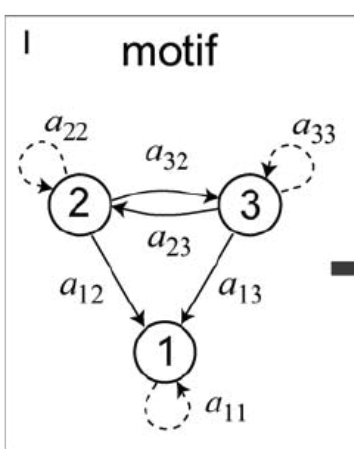

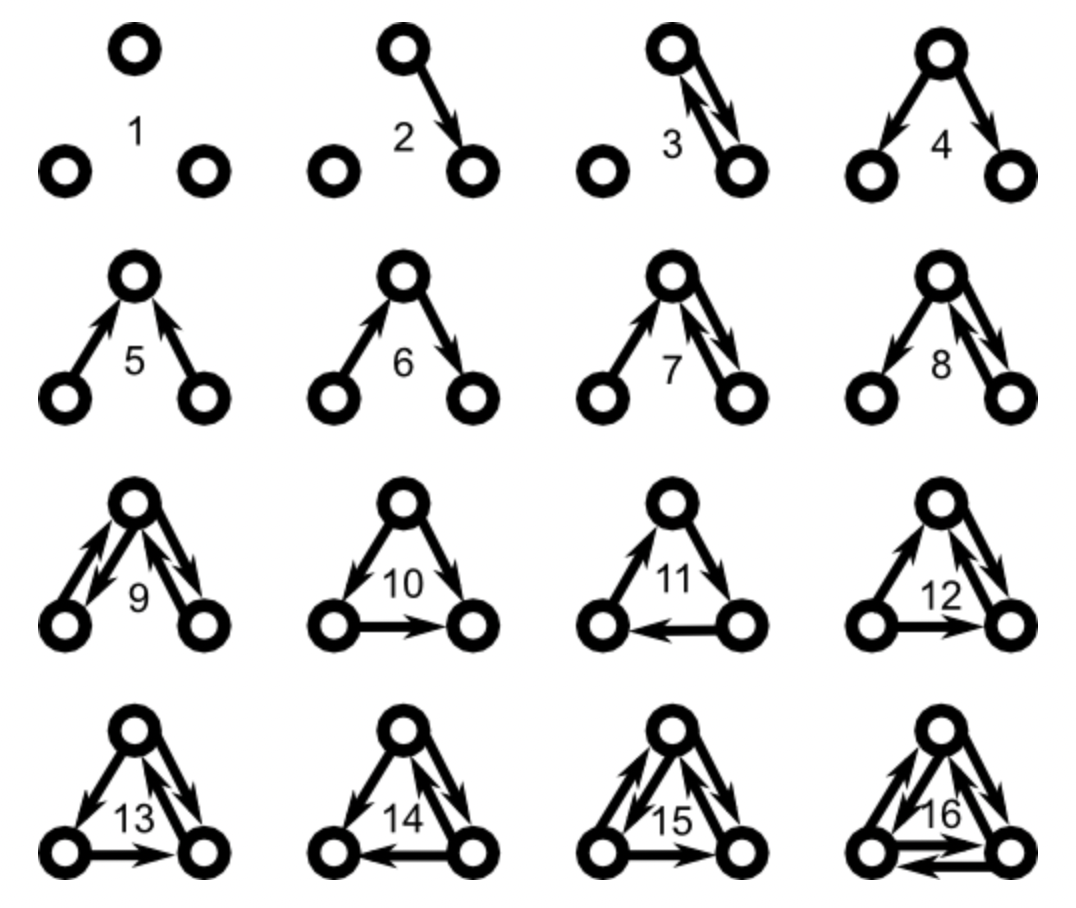

```
* Each node has its own dynamic - e.g. AR
```
```
* Each interaction has its own dynamic - e.g. OU or PID
```
```
* Feedback is modeled by mutual coupling between two or more regions 
    * Instead of adding the input signal with the feedback signal, the signal fed back into the input is coupled with the input
* Delay between regions 
    * Single time point (ODE) 
        * Assume delay between region is too short to be captured in dt
    * Or defined time delay (DDE) 
        * See example below; \tau_B determine the delay between ROIs
        * e.g. \tau_BX > \tau_BY → X affect Y first and Y feedback X
    * Or this can be modeled by the B(t) but this is under the assumption of B(t) depends on X(t)
        * Assume there is a threshold then we don't have to model it explicitly (not continuous change)
        * Might consider adding it to the simulation (this overlap with the stimulus so might not) 
```
```
* How do we want to model stimulation?
    * See example below; Stimulus affecting B(t) or Y(t)/X(t)?
        * B(t): the coupling is changed by the stimulus 
        * Y(t)/X(t): the regions are changed by the stimulus
    * Assume the stimulus is affecting the rois and coupling in different ways (should add a u(t) term in the B(t) in the example below)
        * Different regions are activated 
        * Different networks are dominating 
```
```
* Do we want the interaction between node and interaction? 
    * Activation/Inhibition
```
```
* Consider if these parts are necessary for the simulation
    1. \tau in the AR term - see how different things look like
    2. Intervention - depends on the purpose of the simulation. feedback or more complicated coupling 
```

\begin{equation*}
dY(t) = \sum_i^t\theta_{Yi} Y(t-\tau_{Yi})dt + B_{XY}(t)X(t-\tau_{BX}) dt + D_{XY}(t)u(t) + dW(t)\\
dX(t) = \sum_i^t\theta_{Xi} X(t-\tau_{Xi})dt + B_{YX}(t)Y(t-\tau_{BY}) dt + D_{YX}(t)u(t) + dW(t)\\
dB_{XY}(t) = -\theta_{BX} (B_{XY}(t) - \mu_{BXY})dt + \sigma dW(t) \\
dB_{YX}(t) = -\theta_{BY} (B_{YX}(t) - \mu_{BYX})dt + \sigma dW(t) \\
dD_{XY}(t) = dW(t) \\
dD_{YX}(t) = dW(t) \\
dW(t) \sim N(\mu, \sigma)
\end{equation*}

X(t): Signal in the input ROI \
Y(t): Signal in the output ROI \
B(t): Coupling between X(t) and Y(t) \
D(t): Coupling with intervention (stimulus) \
W(t): Brownian motion

## References 
[1.](https://mathinsight.org/image/three_node_motifs)
```
Possible network motifs involving 3 nodes 
```
[2.](https://www.researchgate.net/publication/355472071_Interpreting_the_Entire_Connectivity_of_Individual_Neurons_in_Micropatterned_Neural_Culture_With_an_Integrated_Connectome_Analyzer_of_a_Neuronal_Network_iCANN)
```
Neuronal networks by network motifs with 3 ndoes
```

In [ ]:
# Math
import numpy as np
import random

# Solvers
from ddeint import ddeint
from scipy.integrate import solve_ivp

# Printing equations
from sympy import *

# Plotting 
import networkx as nx
import matplotlib.pyplot as plt

## ODE Case
No delay

\begin{equation*}
dY(t) = \theta_{Y} Y(t)dt + B_{XY}(t)X(t) dt + dW(t)\\
dX(t) = \theta_{X} X(t)dt + B_{YX}(t)Y(t) dt + dW(t)\\
dB_{XY}(t) = -\theta_{BX} (B_{XY}(t) - \mu_{BXY})dt + \sigma dW(t) \\
dB_{YX}(t) = -\theta_{BY} (B_{YX}(t) - \mu_{BYX})dt + \sigma dW(t) \\
dW(t) \sim N(\mu, \sigma)
\end{equation*}

X(t): Signal in the input ROI \
Y(t): Signal in the output ROI \
B(t): Coupling between X(t) and Y(t) \
W(t): Brownian motion

In [87]:
def feedbackSystem(t,y,m,noise_std,theta_rep,n_max,n,edge_list,edge_loc,thetaB_rep,meanB_10):
    
    # Initialize the combined derivatives
    combined_derivatives = np.zeros_like(y)

    # Edges
    for i in range(n):  # the first n variables are the coupling
        combined_derivatives[i] = -1/thetaB_rep[i] * (y[i] - meanB_10[i]/10) + noise_std * np.random.normal()

    k = 0 # index for nodes
    l = 0 # index for edges
    # Nodes
    for j in range(n, len(y)):  # the last len(y) - n variables are nodes 
        p = j-n 
        temp_loc = edge_loc[edge_loc!=p]
        combined_derivatives[j] = 1/theta_rep[p] * y[j] + noise_std * np.random.normal() # The AR portion of the signal
        
        # General index
        ind_gen = np.arange(m-1)
        
        # Specific index
        ind_spe = ind_gen+k*2
        
        # Check if the signal is coupled with another region
        for q in ind_gen:
            o = ind_spe[q]
            if edge_list[o] == 1:
                ind_y = y[temp_loc[q]+n]
                combined_derivatives[j] += y[l]*ind_y
                l += 1
                
        k += 1

    return combined_derivatives

### Parameters for the system

In [82]:
# # of nodes
m = 3
    
# Range for AR coeff (the reciprocal)
ARrange = range(90,100)

# Range for mean reversion in OU (the reciprocal)
OUmrrange = range(1,10)

# Range for OU mean (would be devided by 10)
OUmrange = range(-50,50)

noise_std = 10

# Initial condition ranges
# Initial coupling range (would be devided by 10)
ICrange = range(-50,50) 

# Initial node range
INrange = range(1,100)

# Nodes
theta_rep = random.sample(ARrange, k = m)

# Edges
# Max possible # of edges
n_max = m*(m-1)

# # of edges
n = random.randint(0,m*(m-1))

# Define which edge exist and which not
edge_ones = np.ones(n)
edge_zeros = np.zeros(n_max-n)
edge_list = np.concatenate([edge_ones,edge_zeros])
random.shuffle(edge_list) # [21, 31, 12, 32, 13, 23] for 3-nodes case
edge_loc = np.arange(0,m) # an array to indicate nodes

edge_source = []
for ind_ in range(m):
    edge_source.append(np.delete(edge_loc, np.where(edge_loc == ind_)))
    
edge_source = np.array(edge_source).flatten()


thetaB_rep = random.sample(OUmrrange, k = n) 

meanB_10 = random.sample(OUmrange, k = n) # devide the number by 10

#d = random.sample(range(1,100), k =m)

initial_coupling_int = random.sample(ICrange, k = n)
initial_coupling = [x/10 for x in initial_coupling_int]
initial_node = random.sample(INrange, k = m)

initial_conditions = np.concatenate([initial_coupling,initial_node])

In [106]:
init_printing() 
t = symbols('t')
w = symbols('Wdt')
# Edges
var_list = ''
ode_list = []
B_list = []
num_dec = 4
for i in range(n):  # the first n variables are the coupling
    var_str = 'B' + str(i)
    var_list += ' B' + str(i)
    B_ = symbols(var_str, cls=Function)(t)

    B_temp = Eq(B_.diff(t), -1/thetaB_rep[i] * (B_ - meanB_10[i]/10) + w)
    B_list.append(B_temp)
    ode_list.append(B_temp)
    with evaluate(False):
        pprint(Eq(B_.diff(t), -round(1/thetaB_rep[i],num_dec) * (B_ - meanB_10[i]/10) + w))

k = 0 # index for nodes
l = 0 # index for edges
# Nodes
vary_str = ''
for j in range(m):  # the last len(y) - n variables are nodes 
    vary_str += ' Y' + str(k)
    k += 1

Y_ = symbols(vary_str, cls=Function)
if n != 0:
    B_ = symbols(var_list, cls=Function)

Y_list = []
edge_list_Nx = []
#edge_label_Nx = []
for o in range(m):
    
    Y_temp = Y_[o](t)
    
    equ_rhs = 1/theta_rep[o] * Y_temp + w # The AR portion of the signal
    equ_rhs1 = round(1/theta_rep[o],num_dec) * Y_temp + w # The AR portion of the signal

    # General index
    ind_gen = np.arange(m-1)

    # Specific index
    ind_spe = ind_gen+o*2

    # Check if the signal is coupled with another region
    
    for p in ind_spe:
        if edge_list[p] == 1:    
            if n != 1:
                equ_rhs += B_[l](t)*Y_[edge_source[p]](t)
                equ_rhs1 += B_[l](t)*Y_[edge_source[p]](t)
                edge_list_Nx.append((str(Y_[edge_source[p]]), str(Y_[o])))
                #label_sign = '+' if meanB_10[l] > 0 else '-'
                #edge_label_Nx.append(str(Y_[edge_source[p]]) + str(Y_[o]) + label_sign)
                l += 1
            else:
                equ_rhs += B_(t)*Y_[edge_source[p]](t)
                equ_rhs1 += B_(t)*Y_[edge_source[p]](t)
                edge_list_Nx.append((str(Y_[edge_source[p]]), str(Y_[o])))
                #label_sign = '+' if meanB_10[0] > 0 else '-'
                #edge_label_Nx.append(str(Y_[edge_source[p]]) + str(Y_[o]) + label_sign)
                l += 1
        else: 
            equ_rhs = equ_rhs
            equ_rhs1 = equ_rhs1
    
    Y_equ_temp = Eq(Y_temp.diff(t), equ_rhs)
    Y_list.append(Y_equ_temp)
    
    ode_list.append(Y_equ_temp)
    with evaluate(False):
        pprint(Eq(Y_temp.diff(t), equ_rhs1))
        


⎛⎧t  for 1 = 0⎞  0 + 1                                 
⎜⎪            ⎟ d                                      
⎜⎨1  for 1 = 1⎟⋅──────(B₀(t)) = Wdt - 0.5⋅(B₀(t) - 2.6)
⎜⎪            ⎟   dt                                   
⎝⎩0  otherwise⎠                                        
⎛⎧t  for 1 = 0⎞  0 + 1                                    
⎜⎪            ⎟ d                                         
⎜⎨1  for 1 = 1⎟⋅──────(B₁(t)) = Wdt - 0.1429⋅(B₁(t) - 2.0)
⎜⎪            ⎟   dt                                      
⎝⎩0  otherwise⎠                                           
⎛⎧t  for 1 = 0⎞  0 + 1                                    
⎜⎪            ⎟ d                                         
⎜⎨1  for 1 = 1⎟⋅──────(B₂(t)) = Wdt - 0.1111⋅(B₂(t) - 1.5)
⎜⎪            ⎟   dt                                      
⎝⎩0  otherwise⎠                                           
⎛⎧t  for 1 = 0⎞  0 + 1                                    
⎜⎪            ⎟ d                                         
⎜⎨1  for 1 =

In [167]:
dire_Nx = [''.join(element) for element in edge_list_Nx]
sign_Nx = ['+' if i>0 else '-' for i in meanB_10]
Nx_labels = [dire_Nx[i] + sign_Nx[i] for i in range(len(sign_Nx))]

edge_labels_Nx = []
for i in range(len(Nx_labels)):
    try: 
        ind = edge_list_Nx.index(edge_list_Nx[i][::-1])

        temp = Nx_labels[i] +" "+ Nx_labels[ind]
        edge_labels_Nx.append(temp)
    except: 
        edge_labels_Nx.append(Nx_labels[i])

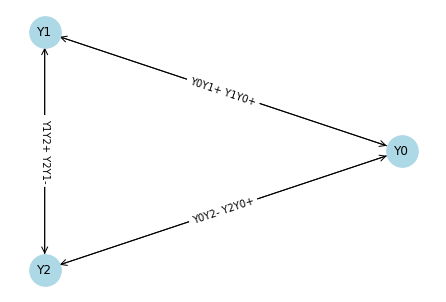

In [170]:

# Create a directed graph
G = nx.DiGraph()

delimiter = " "  # Splitting the string based on space

y_nodes = vary_str.split(delimiter)[1:]

# Add nodes to the graph
G.add_nodes_from(y_nodes)

# Add edges to the graph
G.add_edges_from(edge_list_Nx)

edge_labels = {k: v for k, v in zip(edge_list_Nx, edge_labels_Nx)}

# Draw the network diagram
pos = nx.circular_layout(G)  # Calculate the node positions
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000,
        arrowstyle='->', arrowsize=15)

# Customize the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the diagram
plt.show()

In [97]:
t_span = (0.0, 10.0)  # Start and end times

# Solve the combined SDE system
solution = solve_ivp(lambda t, y: feedbackSystem(t, y, m, noise_std,theta_rep,\
                                                 n_max,n,edge_list,edge_loc,thetaB_rep\
                                                 ,meanB_10), t_span, initial_conditions)

# Extract results
t_sim = solution.t  # Array of time points
Y_sim = solution.y  # Arrays of state variable values at each time point

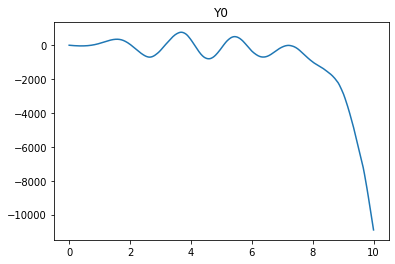

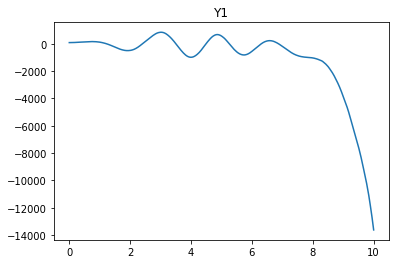

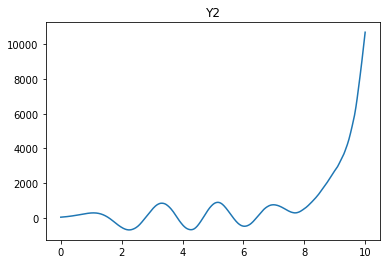

In [98]:
k = 0
for o in np.arange(-m,0):
    fig, ax = plt.subplots()
    ax.plot(t_sim, Y_sim[o])
    title = 'Y' + str(k)
    plt.title(title)
    k+=1

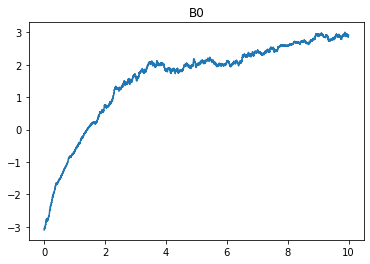

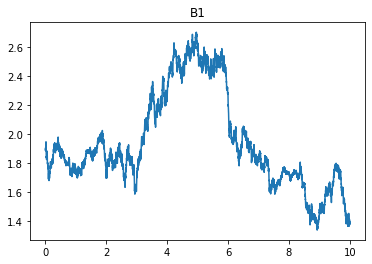

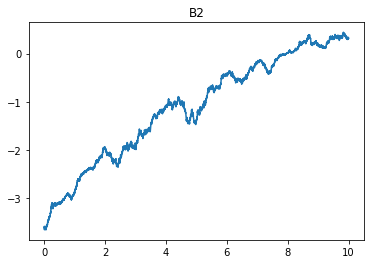

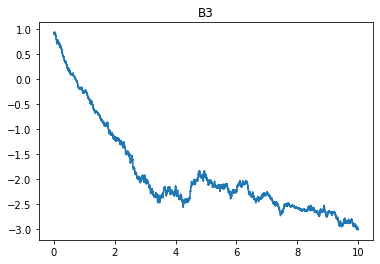

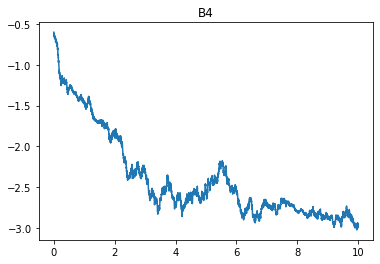

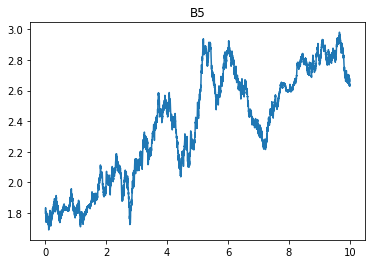

In [90]:
k = 0
for o in np.arange(0,n):
    fig, ax = plt.subplots()
    ax.plot(t_sim, Y_sim[o])
    title = 'B' + str(k)
    plt.title(title)
    k+=1

## DDE Case
Time delay between region

\begin{equation*}
dY(t) = \theta_{Y} Y(t)dt + B_{XY}(t)X(t-\tau_{BX}) dt + dW(t)\\
dX(t) = \theta_{X} X(t)dt + B_{YX}(t)Y(t-\tau_{BY}) dt + dW(t)\\
dB_{XY}(t) = -\theta_{BX} (B_{XY}(t) - \mu_{BXY})dt + \sigma dW(t) \\
dB_{YX}(t) = -\theta_{BY} (B_{YX}(t) - \mu_{BYX})dt + \sigma dW(t) \\
dW(t) \sim N(\mu, \sigma)
\end{equation*}

X(t): Signal in the input ROI \
Y(t): Signal in the output ROI \
B(t): Coupling between X(t) and Y(t) \
W(t): Brownian motion

## Examples 

In [ ]:
from pylab import array, linspace, subplots
from pylab import cos, linspace, subplots

/Users/theok/miniforge3/lib/python3.9/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([g(tt[0])] + results)


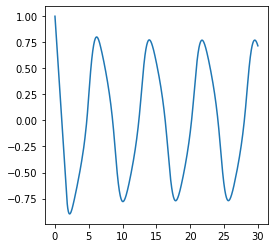

In [3]:

def model(Y, t):
    return -Y(t - 3 * cos(Y(t)) ** 2)


def values_before_zero(t):
    return 1


tt = linspace(0, 30, 2000)
yy = ddeint(model, values_before_zero, tt)

fig, ax = subplots(1, figsize=(4, 4))
ax.plot(tt, yy)
ax.figure.savefig("variable_delay.jpeg")

Computing for d=0.00
Computing for d=0.20
Computing for d=0.40
Computing for d=0.60


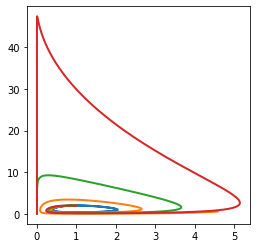

In [4]:
def model(Y, t, d):
    x, y = Y(t)
    xd, yd = Y(t - d)
    return array([0.5 * x * (1 - yd), -0.5 * y * (1 - xd)])


g = lambda t: array([1, 2])
tt = linspace(2, 30, 20000)

fig, ax = subplots(1, figsize=(4, 4))

for d in [0, 0.2, 0.4, 0.6]:
    print("Computing for d=%.02f" % d)
    yy = ddeint(model, g, tt, fargs=(d,))
    # WE PLOT X AGAINST Y
    ax.plot(yy[:, 0], yy[:, 1], lw=2, label="delay = %.01f" % d)

ax.figure.savefig("lotka.jpeg")

/Users/theok/miniforge3/lib/python3.9/site-packages/scipy/integrate/_ode.py:1013: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


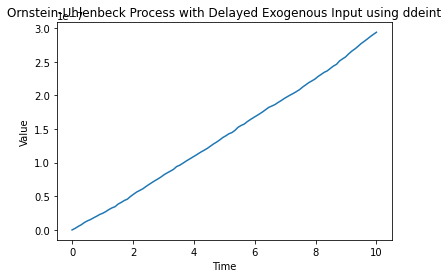

In [8]:
# Define the Ornstein-Uhlenbeck process with delayed exogenous input
def ornstein_uhlenbeck_delayed(Y, t, theta, mu, sigma, eta, delay):
    y, y_delayed = Y(t), Y(t - delay) if t >= delay else 0.0
    dy_dt = -theta * (y - mu) + sigma * np.random.randn() + eta * y_delayed
    return dy_dt

# Set up the DDE problem
def dde_problem():
    # Parameters for the Ornstein-Uhlenbeck process
    theta = 0.5  # Rate of mean reversion
    mu = 1.0  # Mean or equilibrium value
    sigma = 0.1  # Volatility

    # Parameters for the delayed exogenous input
    eta = 0.2  # Influence of the delayed input
    delay = 2.0  # Time delay

    return theta, mu, sigma, eta, delay

def values_before_zero(t):
    return 0

# Solve the DDE problem
def solve_dde():
    theta, mu, sigma, eta, delay = dde_problem()
    t = np.linspace(0, 10, 100)  # Time grid
    y0 = [0.0]  # Initial condition

    # Solve the DDE using ddeint
    solution = ddeint(ornstein_uhlenbeck_delayed, values_before_zero, t, fargs=(theta, mu, sigma, eta, delay))

    return t, solution



# Main function
if __name__ == "__main__":
    t, values = solve_dde()

    # Plot the results
    plt.plot(t, values)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Ornstein-Uhlenbeck Process with Delayed Exogenous Input using ddeint')
    plt.show()


## Extra codes

### Store all symbolic expression together before printing

In [71]:
'''
t = symbols('t')
w = symbols('Wdt')
# Edges
var_str = ''
for i in range(n):  # the first n variables are the coupling
    var_str += ' B' + str(i)
    
B_ = symbols(var_str, cls=Function)
for j, var_temp in evaluate(B_):
    with evaluate(False):
        pprint(Eq(B_[j](t).diff(t), -1/thetaB_rep[i] * (B_[j](t) - meanB_10[j]/10) + w, simplify = False))
        '''

"\nt = symbols('t')\nw = symbols('Wdt')\n# Edges\nvar_str = ''\nfor i in range(n):  # the first n variables are the coupling\n    var_str += ' B' + str(i)\n    \nB_ = symbols(var_str, cls=Function)\nfor j, var_temp in evaluate(B_):\n    with evaluate(False):\n        pprint(Eq(B_[j](t).diff(t), -1/thetaB_rep[i] * (B_[j](t) - meanB_10[j]/10) + w, simplify = False))\n        "